# AER Cleaning

This notebook walks through how the AER articles were sorted into categories of articles and non-articles.

## Load 

In [1]:
from tokenize import Ignore
from numpy import NaN
import pandas as pd
import numpy as np
from difflib import SequenceMatcher
import multiprocessing as mp
import time
from os import path
import os
from pathlib import Path
#from PyPDF2 import PdfFileReader, PdfFileWriter
import re
import matplotlib.pyplot as plt    

## Load Files

Replace the file paths below to match local file paths. Note: comment out files that are not available eg: datadumps.

In [2]:
masters = pd.read_excel('/Users/MattJohnson/Desktop/Refs + affiliations/Affiliations/Master lists/Processed/AER_processed.xlsx')
scopus = pd.read_excel('/Users/MattJohnson/Desktop/Refs + affiliations/Affiliations/Scopus/AER_SCOPUS.xlsx')
pivots = pd.read_excel('/Users/MattJohnson/Desktop/Refs + affiliations/Affiliations/Master lists/Pivot lists/AER_pivots.xlsx')

pd.set_option('display.max_colwidth', None)

## Some random checks on the masters list

My assumption is that all data without author names must be miscellaneous documents like reports by the committee, forewords, front matters etc.. The goal of this notebook is to check for certain that all the documents without author names are actually miscellaneous documents and then classify them as miscellaneous (MISC). Hence, first we group everything the data by title to see the repetitive general content that can likely be removed.

In [ ]:
pd.set_option('display.max_rows',masters.shape[0])
temp=masters['title'].str.lower().value_counts()
pd.DataFrame(temp[temp>1])

Some repetitions are due to multiple comments. Now consider this list in absence of author names.

In [ ]:
temp1=masters[masters['authors'].isna()]['title'].str.lower().value_counts()
pd.DataFrame(temp1)

Notice that titles with duplicates of greater or equal to 4 are miscellaneous items and so they are classified in bulk

In [5]:
temp2=masters[(masters['content_type'].isna()==True)]['title'].str.lower().value_counts()
removal=list(temp2[temp2>=4].index)
masters.loc[masters.title.str.lower().isin(removal),'content_type']='MISC'

Classify some titles via regex

In [6]:
masters.loc[masters['title'].str.lower().str.contains('books and periodicals')==True,'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.match(r'^editorial')==True,'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.match(r'^announcement')==True,'content_type']='MISC'
masters.loc[masters['title'].str.strip().str.len()<4,'content_type']='MISC'
#masters[masters.content_type=='MISC']


In [7]:
scopus.rename(columns = {'abstract':'abstract2', 'title':'title2', 'authors':'authors2'}, inplace = True)
scopus['pages2']=scopus['pages']
masters['pages']=masters['pages'].str.strip()  
masters.loc[masters.title.str.lower() == "back matter", 'pages'] = NaN  

## Classifying other content

In [8]:
sum(masters.content_type.isna())
#masters.shape[0]

0

In [9]:
masters.loc[masters['authors'].str.lower().str.match(r'^review(ed|) by(.*)')==True,'content_type']='Review' #reviews
masters.loc[(masters['title'].str.lower().str.match(r'(.*) by (.*)')==True) & (masters.authors.isna()==True),'content_type']='Review2' 
#possible reviews that don't have author names
masters[(masters['content_type']=='Review2') | (masters['content_type']=='Review')].shape[0] #reviews

7166

In [10]:
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*(:|\?).*comment.*$')==True,'content_type']='Comment'
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*comment$')==True,'content_type']='Comment'
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'(a further|further) comment.*$')==True,'content_type']='Comment'
masters[masters['content_type']=='Comment'].shape[0] 
#comments

809

In [11]:
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*(:|\?) (|a )reply(| to.*)$')==True,'content_type']="Reply"
masters[masters['content_type']=='Reply'].shape[0]

505

In [12]:
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*(:|\?|).*rejoinder.*$')==True,'content_type']="Rejoinder"
masters[masters['content_type']=='Rejoinder'].shape[0]


52

In [13]:
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*: (|a )discussion$')==True,'content_type']="Discussion"
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'(^|a )discussion(|.*)$')==True,'content_type']="Discussion"
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*:.*(|a )discussion(|s)$')==True,'content_type']='Discussion'
masters[masters['content_type']=='Discussion'].shape[0]


592

In [14]:
masters.loc[masters['content_type'].isna(),'content_type']="Article"
masters[masters['content_type']=='Article'].shape[0]
masters.shape

(27418, 12)

## Consider the pivots file
At times, conference papers are structured differently to normal articles. Hence, it may be necessary to distinguish conference papers from common articles. The next code block separates special issues (S) from normal issues (N)

In [15]:
pivots.loc[pivots.Jstor_issue_text.str.lower().str.match(r'(.*)(supplement|proceedings|annual meeting|survey)(.*)'),'type']="S"
pivots.loc[pivots.type.isna(),'type']='N'
pivots.type.value_counts()

N    495
S    139
Name: type, dtype: int64

Merge masterlist and pivot list

In [16]:
result = pd.merge(masters, pivots[['issue_url','year','volume','issue','journal','type']], how="left", on=["issue_url", "issue_url"])
result.to_excel('/Users/MattJohnson/Desktop/Refs + affiliations/Affiliations/Master lists/Testing/AER_master_pivots.xlsx')

## Summary

In [17]:
pd.DataFrame(result.content_type.value_counts())

,content_type
Article,12579
Review,7144
MISC,5715
Comment,809
Discussion,592
Reply,505
Rejoinder,52
Review2,22


## This section aims to match up Scopus records and Jstor articles
If an article's affiliations, citations or abstracts are recorded on Scopus. matching up the Scopus data is useful for comparing the textual accuracy of OCR parsers. I use volume, issue, year and page numbers which are common to both the scopus data and the Jstor metadata to match articles. 

Then I use a sequence comparison between the journal titles of the matched articles to decide if the scopus data has been matched correctly. If the match ratio is below 70%, the title is investigated and if wrong, the scopus data for that matched article is either corrected or discarded. 

The next section reads in the processed data previously saved. Please make sure the path in the variable 'cleaned' matches the file path on your local machine.

In [31]:
#cleaned=pd.read_excel('C:\\Users\\sjwu1\\Journal_Data\\datadumps\\processed\\RES_processed.xlsx')
#cleaned = pd.read_excel('/Users/MattJohnson/Desktop/Refs + affiliations/Affiliations/Master lists/Processed/RES_processed.xlsx')

scopus = pd.read_excel('/Users/MattJohnson/Desktop/Refs + affiliations/Affiliations/Scopus/AER_SCOPUS.xlsx')

cleaned = masters
cleaned['volume']=cleaned['volume'].astype(int)
scopus['pages']=scopus['pages'].str.strip()
#print(scopus.shape)
#cleaned.year.unique()

cleaned  = cleaned[cleaned['year'] >= 1940]
cleaned  = cleaned[cleaned['year'] <= 2016]
cleaned  = cleaned[cleaned['content_type'] == 'Article']
cleaned.reset_index(inplace=True)
print(cleaned[['year','volume','issue','pages']].dtypes)

print(cleaned.shape)
cleaned.to_excel('/Users/MattJohnson/Desktop/Refs + affiliations/Affiliations/Master lists/Testing/AER_cleaned.xlsx')

scopus['document type'] = scopus['document type'].str.strip()

scopus  = scopus[scopus['year'] >= 1940]
scopus  = scopus[scopus['year'] <= 2016]
scopus  = scopus[scopus['document type'] == 'Article']
scopus.reset_index(inplace=True)
scopus.to_excel('/Users/MattJohnson/Desktop/Refs + affiliations/Affiliations/Master lists/Testing/scopus_cleaned.xlsx')
print(scopus[['year','volume','issue','pages']].dtypes)
print(scopus.shape)

year      float64
volume      int64
issue      object
pages      object
dtype: object
(10733, 13)
year       int64
volume     int64
issue     object
pages     object
dtype: object
(2721, 15)


This is the number of entries on Scopus

In [19]:
#Note that we only have data up to 2018 in the masterlists because of the moving wall on JSTOR
print(sum(scopus['year']<2019))
print(scopus.shape)

2721
(2721, 15)


Merge on year, issue, volume and pages.

In [30]:
Merged=pd.merge(cleaned, scopus, on=['year','volume','pages'], how='left')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
print(sum(Merged['title_y'].isna()==False))

2645


Check how many of the scopus entries matched.

In [28]:

#Merged.to_excel('/Users/MattJohnson/Desktop/Refs + affiliations/Affiliations/Master lists/Testing/AER_master_scopus_base.xlsx')

498959


KeyboardInterrupt: 

Quick maths: There are 3970 total documents for Review of econ. studies (RES) between, 3180 of these are actual articles. Scopus matched up to 2698 entries in the RES masterlist. This means there is 146 entries in Scopus that do not match up to something in the masterlists. And atleast 1272 entries in the masterlist without scopus records. Conclusion: 60% coverage ain't too bad! Now let's see if there is actual references and affiliations or did Scopus just bullshit us all.

Consider the titles that have a less than 70% match.

In [33]:
count=0
for m in Merged.index:
    
    if(pd.isna(Merged.iloc[m]['title_y'])==False):
        ratio=SequenceMatcher(None, Merged.iloc[m]['title_x'].lower(), Merged.iloc[m]['title_y'].lower()).ratio()
        if((ratio<0.7) & (Merged.iloc[m]['content_type']!='MISC')):
            print(Merged.iloc[m]['year'])
            print(ratio)
            count+=1
            if pd.isna(Merged.iloc[m]['authors_x'])==False:
                A_ratio=SequenceMatcher(None, Merged.iloc[m]['authors_x'].lower(), Merged.iloc[m]['authors_y'].lower()).ratio()
                print(A_ratio)
            else:
                print('Author issue')
                print(Merged.iloc[m]['authors_x'])
                print(Merged.iloc[m]['authors_y'])
            print(Merged.iloc[m]['stable_url'])
            print('vol: '+str(Merged.iloc[m]['volume']))
            #print('issue: '+str(Merged.iloc[m]['issue']))
            print('pages: '+Merged.iloc[m]['pages'])
            print('jstor: '+Merged.iloc[m]['title_x'])
            print('scopus: '+Merged.iloc[m]['title_y'])
            print('jstor: '+str(Merged.iloc[m]['authors_x']))
            print('scopus: '+str(Merged.iloc[m]['authors_y']))
            print('scopus index: '+str(scopus[scopus['title']==Merged.iloc[m]['title_y']].index))
            print(m)
            print()
print(count)

2014.0
0.16666666666666666
0.23809523809523808
https://www.jstor.org/stable/43495358
vol: 104
pages: 3814-3840
jstor: Ambiguity Aversion with Three or More Outcomes
scopus: Hospital choices, hospital prices, and financial incentives to physicians?
jstor: Mark J. Machina
scopus: Ho, K.--a--
Pakes, A.--b-- 
scopus index: Int64Index([2407], dtype='int64')
476

2014.0
0.30601092896174864
0.2727272727272727
https://www.jstor.org/stable/43495359
vol: 104
pages: 3841-3884
jstor: Hospital Choices, Hospital Prices, and Financial Incentives to Physicians
scopus: Consumption and debt response to unanticipated income shocks: Evidence from a natural experiment in Singapore?
jstor: Kate Ho and Ariel Pakes
scopus: Agarwal, S., Qian, W.
scopus index: Int64Index([2408], dtype='int64')
477

2014.0
0.3522012578616352
0.19672131147540983
https://www.jstor.org/stable/43495360
vol: 104
pages: 3885-3920
jstor: Is It Whom You Know or What You Know? An Empirical Assessment of the Lobbying Process
scopus: Reput

This code is used to search for title or author matches in the jstor masterlists to find entries to correct the scopus data.

In [34]:
#search='Bargaining With Two-Sided Incomplete Information: An Infinite Horizon Model With Alternating Offers'
#search='Acyclic choice without the pareto principle'
#search='On Bayesian Implementable Allocations'
#search='How fast do rational agents learn'
search='A. P. lerner'
for i in cleaned.index:
    if pd.isna(cleaned.iloc[i]['authors'])==False:
        c=SequenceMatcher(None, cleaned.iloc[i]['authors'].lower(), search).ratio()
        if c>0.7:
            print(cleaned.iloc[i])

index                                                  13583
stable_url              https://www.jstor.org/stable/1808989
authors                                         A. P. Lerner
title                                 The Analysis of Demand
abstract                                                 NaN
content_type                                         Article
issue_url       https://www.jstor.org/stable/10.2307/i331384
pages                                                783-797
year                                                  1962.0
volume                                                    52
issue                                                    4.0
journal                                                  AER
type                                                       N
Name: 8832, dtype: object


Now let's do some manual corrections.

There are some issues in the masterlists caused by the scraper logic. If there was a NaN in the page reference, the previous entries' page numbers were used which duplicated the uniqueness of year-volume-issue-pages. This is to be corrected now.

In [35]:
#get a dataframe of counts
x=pd.DataFrame(cleaned[['year','volume','issue','pages']].value_counts()).reset_index()
k=x[x[0]>1]
k

,year,volume,issue,pages,0
0,1972.0,62,1-2,238,2
1,1940.0,30,2.0,353,2


Now let's remove the duplicates and text issues. The first if statement resets the page numbers to remove leftover doi references. The second searches for duplicates and if it is a "Front Matter" or duplicates the pages of an actual article then the pages are set to None.

In [36]:
count=0
for i in cleaned.index:
    m=cleaned.iloc[i]
    if 'http' in str(cleaned.loc[i, 'pages']):
        cleaned.loc[i, 'pages']=cleaned.loc[i, 'pages'].split(')')[0]
    if sum((k['year']==m['year']) & (k['volume']==m['volume']) & (k['issue']==m['issue']) & (k['pages']==m['pages']))==1:
        if m.title.strip()=='Front Matter':
            cleaned.loc[i,'pages']=None
        if pd.isna(m.authors)==False:
            temp=cleaned[(cleaned['year']==m['year']) & (cleaned['volume']==m['volume']) & (cleaned['issue']==m['issue']) & (cleaned['pages']==m['pages'])]
            for j in temp.index:
                if pd.isna(temp.loc[j, 'authors'])==True:
                    cleaned.loc[j,'pages']=None
        count+=1
        #print(m)

print(count)

4


Re-merge the scopus data and the cleaned masterlists

In [37]:
Merged=pd.merge(cleaned, scopus, on=['year', 'volume','pages'], how='left')

Check for whether there is an issue in document type and correct it.

In [28]:
pd.DataFrame(Merged[Merged['document type'].str.len()>100])
Merged.loc[170,'document_type']='Article'
Merged.loc[174,'document_type']='Article'

Note: the datadump does not have any references for res. So merged data is saved directly after renaming.

In [38]:
Merged.rename(columns = {'authors_x':'Jstor_authors', 'title_x':'Jstor_title', 'abstract_x':'Jstor_abstract', 'journal_x':'Jstor_journal', 'authors_y':'scopus_authors','title_y':'scopus_title', 'abstract_y':'scopus_abstract', 'journal_y':'scopus_journal' }, inplace = True)

saving...

In [39]:
Merged.to_excel('/Users/MattJohnson/Desktop/Refs + affiliations/Affiliations/Master lists/Merged_scopus/AER_processed_scopus.xlsx')

# Merged dataset field description

This is a description of fields in the Merged dataset that combines JPE masterlist, pivot list, Scopus data pre-2018. The Merged dataset is stored in RES_M_sco_du.xlsx. Note that RES does not contain any reference data scraped from JSTOR.

    'stable_url' : JSTOR url for article 
    'Jstor_authors' : Author names recorded by JSTOR
    'Jstor_title' : Title of article recorded by JSTOR
    'Jstor_abstract' : abstract recorded by JSTOR nb: this is blank at the moment
    'content_type' : Article type determined during cleaning. Includes MISC for miscellaneous, Reviews, Note, Comment, Rejoinder and Article categorizations
    'issue_url' : url of issue article belongs to on JSTOR
    'pages' : pages as recorded by JSTOR
    'year' : Year of publication recorded by JSTOR
    'volume' : Volume of article recorded by JSTOR
    'issue' : issue of article recorded by JSTOR
    'Jstor_journal' : journal name JSTOR
    'type' : Type of issue determined during cleaning. S for special issue. N for normal issue
    'scopus_authors' : Author names recorded by Scopus
    'scopus_title' : Title recorded by Scopus
    'scopus_journal' : Journal name recorded by Scopus
    'DOI' : DOI recorded by scopus
    'affiliations' : affiliations of authors as recorded by scopus
    'scopus_abstract' : abstract of article recorded by scopus
    'citations' : citations of article recorded by scopus
    'document type' : Article type recorded by scopus, may differ from that in cleaning
    'index keywords' : from scopus
    'author keywords' : from scopus 

### Plots of counts
Exploratory analysis of available data in scopus and datadumps.

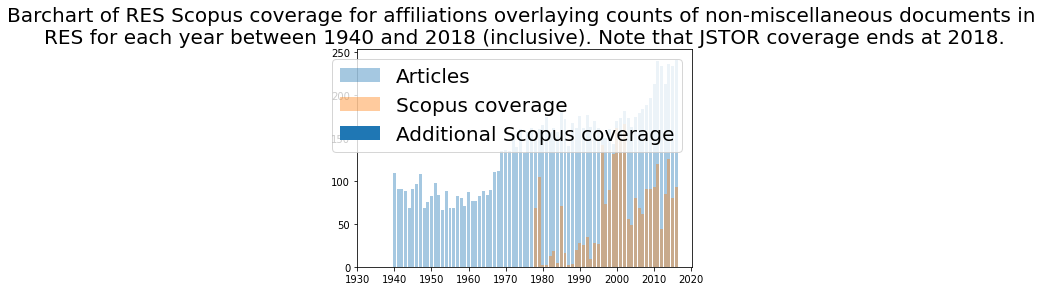

In [40]:
plt.rcParams["figure.figsize"] = (25, 10)
dta=Merged[(Merged['content_type']!='MISC')]['year'].value_counts()
plt.bar(dta.index,dta, label='Articles', alpha=0.4)
dta2=Merged[(Merged['affiliations'].isnull()==False) & (Merged['content_type']!='MISC')]['year'].value_counts()
dta3=scopus[(scopus['citations'].isnull()==False) & (scopus['year']>2018)]['year'].value_counts()
plt.bar(dta2.index, dta2, label='Scopus coverage', alpha=0.4)
plt.bar(dta3.index, dta3, label='Additional Scopus coverage', alpha=0.4)
plt.title('Barchart of RES Scopus coverage for affiliations overlaying counts of non-miscellaneous documents in \nRES for each year between 1940 and 2018 (inclusive). Note that JSTOR coverage ends at 2018.', fontsize=20)
plt.xticks(np.arange(1930, 2030, 10))
plt.legend(prop={'size': 20})


In [45]:
missing_aff=Merged[(Merged['affiliations'].isnull()) & (Merged['content_type']!='MISC')][['year','stable_url','issue_url','affiliations','Jstor_title']]
have_aff =Merged[(Merged['affiliations'].isnull()==False) & (Merged['content_type']!='MISC')][['year','stable_url','issue_url','affiliations','Jstor_title']]
print(have_aff.shape)
print(missing_aff.shape)
missing_aff.to_excel('/Users/MattJohnson/Desktop/Refs + affiliations/Affiliations/Master lists/Merged_scopus/AER_missing_aff_scopus.xlsx')

(2525, 5)
(8212, 5)


Some years of coverage are almost complete, it may not be necessary to use OCR to extract affiliations. I propose there's only a real point to set up the OCR if there if more than 80% of the articles in a issue are missing affiliations. 

Consider the missing counts of articles per issue by getting counts of total per issue and scopus affiliations per issue.

In [38]:
sc_aff=Merged[(Merged['affiliations'].isnull()==False) & (Merged['content_type']!='MISC')][['year','volume','issue']].value_counts()
js_aff=Merged[(Merged['content_type']!='MISC')][['year','volume','issue']].value_counts()

Create a dataframe of counts of missing article affiliations per issue and merge that with the total articles per issue and calculate the percentage of missing article affiliations.

In [39]:
difference=pd.DataFrame(js_aff-sc_aff).reset_index()  #get difference
difference=pd.merge(difference, js_aff.reset_index(), on=['year', 'issue','volume'], how='right').sort_values(['year','issue','volume'])
difference['retrieval_req']=difference['0_x']/difference['0_y']
difference.rename(columns = {'0_x':'missing', '0_y':'total'}, inplace = True)
difference['retrieval_req'] = difference['retrieval_req'].fillna(1)
difference[difference['year']>=1940] # if missing is NaN that means the whole issue is missing.


,year,volume,issue,missing,total,retrieval_req
87,1940,55,1.0,1.0,11,0.090909
61,1940,54,2.0,5.0,12,0.416667
118,1940,54,3.0,2.0,10,0.200000
107,1940,54,4.0,7.0,11,0.636364
98,1941,56,1.0,3.0,11,0.272727
131,1941,55,2.0,4.0,10,0.400000
202,1941,55,3.0,0.0,9,0.000000
286,1941,55,4.0,1.0,7,0.142857
205,1942,57,1.0,0.0,9,0.000000
203,1942,56,2.0,0.0,9,0.000000


There are on average 10 articles per issue. And for older papers, there are only 5 to 7 articles in the issue. Hence, if there are only one or two missing affiliations in that issue it makes sense to collect them manually since setting up the rules for OCR to find the affiliations in just one paper is more time consuming than looking it up.